In [1]:
# データの用意
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = sns.load_dataset('iris')
df.iloc[0,1] = np.NaN # わざと欠損値を作る

df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,NaN,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [16]:
import pandas_profiling as pdp
from IPython.display import HTML

profile = pdp.ProfileReport(df)
profile.to_file(output_file="profile.html")
HTML(filename='profile.html')

AttributeError: module 'pandas_profiling' has no attribute 'templates'

In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.simplefilter('ignore')

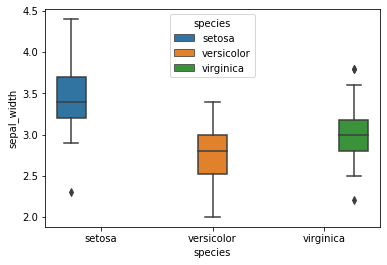

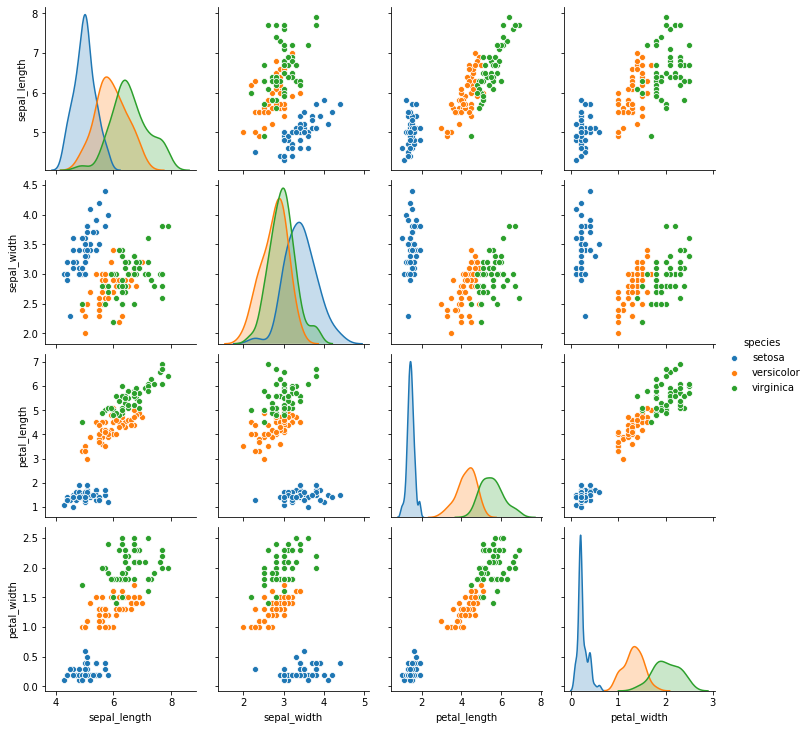

In [5]:
sns.boxplot(x='species',y='sepal_width',hue='species',data=df)
sns.pairplot(df,hue='species')

# データクリーニング

In [6]:
# remove missing value
df = df.dropna()

# 入れ子式の交差検証法で正解率を比べる

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,cross_val_score,KFold

In [8]:
# 将来的にデフォルト値が変更される警告がでないように設定
import warnings
warnings.simplefilter('ignore')

## 1.前処理

In [9]:

df = df.dropna() # 欠損値削除
del df['petal_width'] # データチェックの結果からpetal_lengthと相関の強いpetal_widthは削除

In [11]:
# カテゴリデータであるspeciesを数値データに変換
df['species'] = df['species'].map(
{'setosa':0,'versicolor':1,'virginica':2})

In [12]:
df.head()

,sepal_length,sepal_width,petal_length,species
1,4.9,3.0,1.4,0
2,4.7,3.2,1.3,0
3,4.6,3.1,1.5,0
4,5.0,3.6,1.4,0
5,5.4,3.9,1.7,0


In [13]:
# numpyの変数を用意
y = np.array(df['species'])
X = np.array(df.iloc[:,0:3]) # 0,1,2行目の3つを取得

In [14]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [18]:
X[0:5,:]

array([[4.9, 3. , 1.4],
       [4.7, 3.2, 1.3],
       [4.6, 3.1, 1.5],
       [5. , 3.6, 1.4],
       [5.4, 3.9, 1.7]])

## 2.交差検証の用意


## 2.1 outer_loopの設定

In [19]:
outer_loop = KFold(n_splits=5,shuffle=True,random_state=0)

## 2.2 inner_loop

In [20]:
inner_loop = KFold(n_splits=4,shuffle=True,random_state=0)

## 2.3 パイプライン生成

In [21]:
pipe = Pipeline([('scaler',StandardScaler()),('logistic',LogisticRegression())])

## 2.4 グリッドサーチの設定

In [22]:
# 比較するハイパーパラメータ設定
param_grid = {
    'logistic__C':[1,10,100],
}

In [23]:
gs = GridSearchCV(
estimator=pipe,param_grid=param_grid,scoring='accuracy',cv=inner_loop)

## 3.学習

In [24]:
val_result = np.zeros((5,3)) # outer_loop数　×　ハイパーパラメータの種類
ol_index = 0 # outer_loop のindex

In [26]:
# outer_loop
for train_val_index,test_index in outer_loop.split(X):
    X_train_val,X_test = X[train_val_index],X[test_index]
    y_train_val,y_test = y[train_val_index],y[test_index]
    
    # inner_loop
    gs.fit(X_train_val,y_train_val) # trainで学習し，valで評価
    val_result[ol_index] = gs.cv_results_['mean_test_score']
    
    print('outer_loopの結果その{}:{}'.format(ol_index+1,val_result[ol_index]))
    ol_index += 1

outer_loopの結果その1:[0.85714286 0.89915966 0.92436975]
outer_loopの結果その2:[0.80672269 0.88235294 0.94957983]
outer_loopの結果その3:[0.86554622 0.89915966 0.94117647]
outer_loopの結果その4:[0.84033613 0.88235294 0.90756303]
outer_loopの結果その5:[0.83333333 0.90833333 0.95      ]


## 4.評価

In [27]:
print('--\n outer_loopの平均結果:{}\n--'.format(val_result.mean(axis=0)))

--
 outer_loopの平均結果:[0.84061625 0.89427171 0.93453782]
--


## 5.テストデータで性能確認


In [28]:
clf_pipe = Pipeline([('scaler',StandardScaler()),('logistic',LogisticRegression(C=100))])
il_index = 0 # inner_loopのindex
test_result = np.zeros(5*4) # outer_loop×inner_loop

In [33]:
#  outer_loop
for train_val_index,test_index in outer_loop.split(X):
    X_train_val,X_test = X[train_val_index],X[test_index]
    y_train_val,y_test = y[train_val_index],y[test_index]
    
    # inner_loop
    for train_index,val_index in inner_loop.split(X_train_val):
        X_train,X_val = X_train_val[train_index],X_train_val[val_index]
        y_train,y_val = y_train_val[train_index],y_train_val[val_index]
        
        clf_pipe.fit(X_train,y_train) # trainで学習
        test_result[il_index] = clf_pipe.score(X_test,y_test) # testの正解率を求める
        
        print('inner_loopの結果その{}:{}'.format(il_index + 1,test_result[il_index]))
        il_index += 1

print('--\n テストデータの平均正解率:{}'.format(test_result.mean()))

inner_loopの結果その1:0.9
inner_loopの結果その2:0.9
inner_loopの結果その3:0.9333333333333333
inner_loopの結果その4:0.9666666666666667
inner_loopの結果その5:0.8666666666666667
inner_loopの結果その6:0.9
inner_loopの結果その7:0.9
inner_loopの結果その8:0.8666666666666667
inner_loopの結果その9:0.9
inner_loopの結果その10:0.8666666666666667
inner_loopの結果その11:0.8666666666666667
inner_loopの結果その12:0.9333333333333333
inner_loopの結果その13:0.9333333333333333
inner_loopの結果その14:1.0
inner_loopの結果その15:1.0
inner_loopの結果その16:1.0
inner_loopの結果その17:0.9310344827586207
inner_loopの結果その18:0.9655172413793104
inner_loopの結果その19:0.9655172413793104
inner_loopの結果その20:0.9655172413793104
--
 テストデータの平均正解率:0.9280459770114943
